In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller, kpss

%matplotlib inline 
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

# Lendo os datasets de treino e teste

In [5]:
data = pd.read_csv('../../data/ElectricDemandForecasting-DL-master_data_hourly_20140102_20191101_train.csv')


In [6]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [7]:
data['datetime']=pd.to_datetime(data['datetime'], utc=True)

In [8]:
data['ano']=data['datetime'].dt.year
data['mes']=data['datetime'].dt.month
data['hora']=data['datetime'].dt.hour
data['min']=data['datetime'].dt.minute

In [9]:
data.head()

,value,percentage,datetime,ano,mes,hora,min
0,24256,0.340316,2014-01-01 23:00:00+00:00,2014,1,23,0
1,24260,0.343019,2014-01-01 23:10:00+00:00,2014,1,23,10
2,23689,0.340178,2014-01-01 23:20:00+00:00,2014,1,23,20
3,23349,0.339301,2014-01-01 23:30:00+00:00,2014,1,23,30
4,22896,0.337122,2014-01-01 23:40:00+00:00,2014,1,23,40


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245376 entries, 0 to 245375
Data columns (total 7 columns):
value         245376 non-null int64
percentage    245376 non-null float64
datetime      245376 non-null datetime64[ns, UTC]
ano           245376 non-null int64
mes           245376 non-null int64
hora          245376 non-null int64
min           245376 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(5)
memory usage: 13.1 MB


In [22]:
data_abriged=data[data['ano']==2014]

In [42]:
data_abriged_oct=data_abriged[data_abriged['mes']==10]

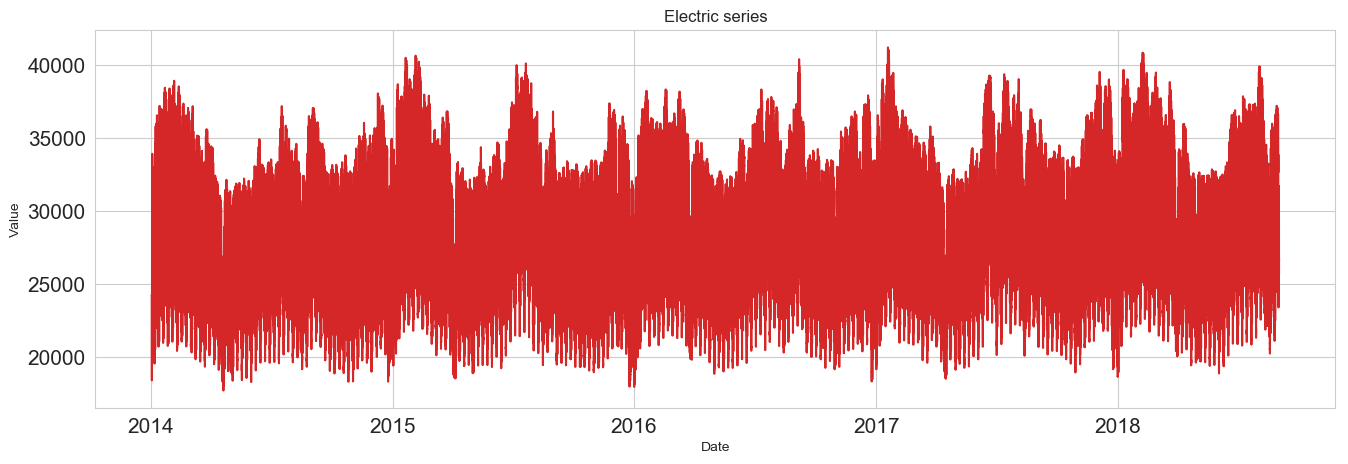

In [23]:
plot_df(data, x=data.datetime, y=data.value, title="Electric series")

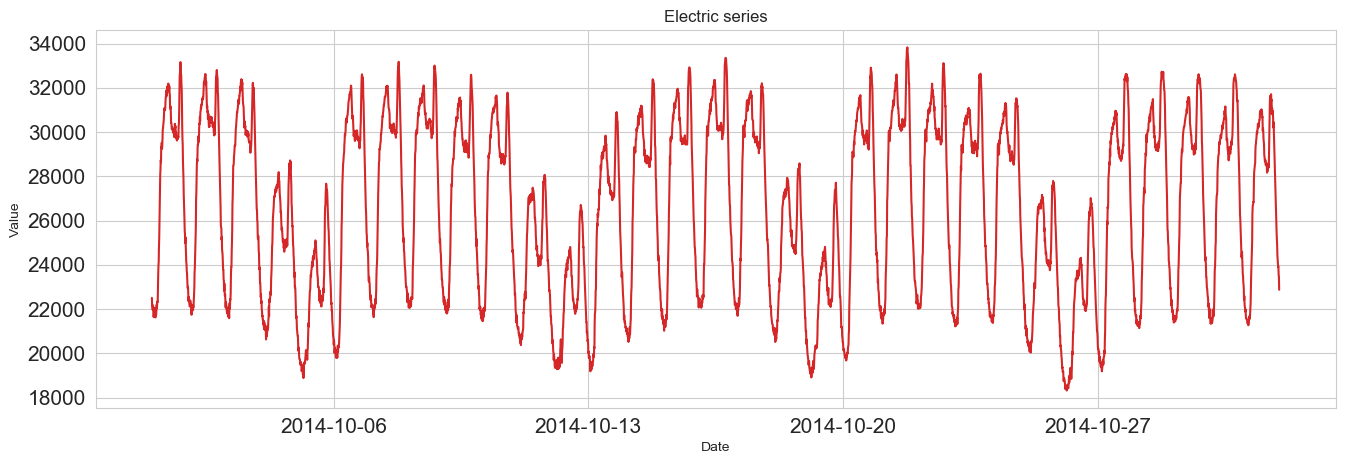

In [25]:
plot_df(data_abriged_oct, x=data_abriged_oct.datetime, y=data_abriged_oct.value, title="Electric series")

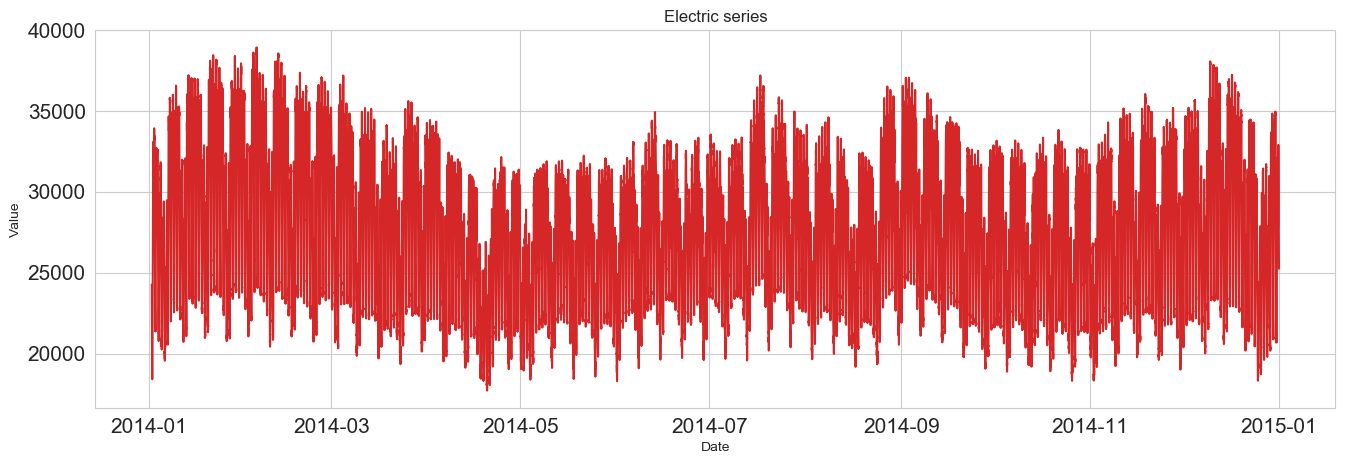

In [26]:
plot_df(data_abriged, x=data_abriged.datetime, y=data_abriged.value, title="Electric series")

In [43]:
data_abriged_oct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4464 entries, 39174 to 43637
Data columns (total 7 columns):
value         4464 non-null int64
percentage    4464 non-null float64
datetime      4464 non-null datetime64[ns, UTC]
ano           4464 non-null int64
mes           4464 non-null int64
hora          4464 non-null int64
min           4464 non-null int64
dtypes: datetime64[ns, UTC](1), float64(1), int64(5)
memory usage: 279.0 KB


# Testes de Dick-Fulley e KPSS

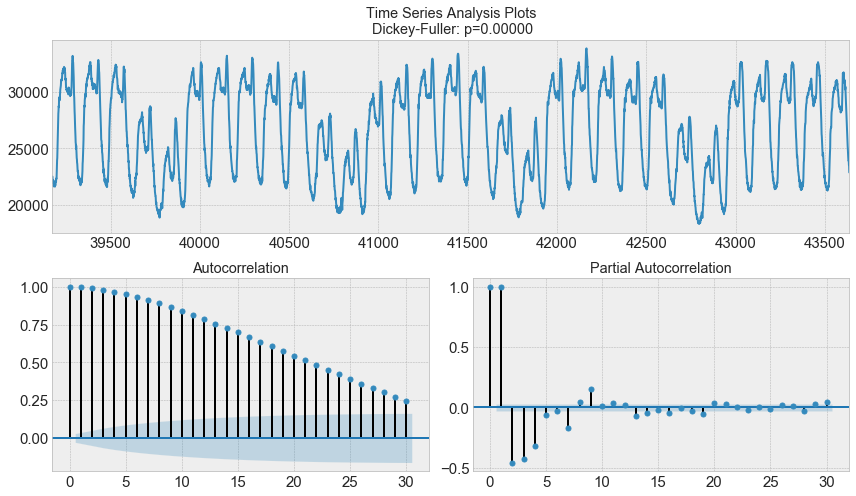

In [44]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data_abriged_oct.value, lags=30)

In [40]:
p_value = sm.tsa.stattools.adfuller(data_abriged_oct.value)[1]
p_value


1.7834514928387004e-16

In [ ]:
## Olhando para o p-value acima, notamos que é muito menor que o limiar de 5% (0.05), rejeitando assim a hipótese nula de que a Série
## não é estacionária. Isso nos confirma que a série é, de fato, estacionária

In [39]:
p_value2 = sm.tsa.stattools.kpss(data_abriged_oct.value)[1]
p_value2

C:\Users\Not\Anaconda2\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


0.1

In [ ]:
## Com o teste KPSS temos o resultado contrário: O p-value acima é maior que o limiar de 5% (0.05), aceitando a hipótese nula de que
## a série é estacionária. Isso nos confirma que a série é, de fato, estacionária